# Twitter project


Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
# Import useful libraries
import pandas as pd
import tensorflow as tf 
import pathlib 
import os
import io
import seaborn as sns 
import numpy as np
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout

In [2]:
# Import the file
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [3]:
# Read the file
print("Loading dataset...")
data = pd.read_csv(io.BytesIO(uploaded["train.csv"]))
print("...Done.")
print()
data.head()

Loading dataset...
...Done.



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Part 1 : Exploring the dataset

In [4]:
# Basics statistics

print("Number of rows : {}".format(data.shape[0]))
print()

print("Number of columns : {}".format(data.shape[1]))
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows : 7613

Number of columns : 5

Basics statistics: 


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



Percentage of missing values: 


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [5]:
#Drop missing values

data = data.dropna(axis=0)
data.shape

(5080, 5)

In [6]:
data.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [7]:
# Verification 

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Percentage of missing values: 


id          0.0
keyword     0.0
location    0.0
text        0.0
target      0.0
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0    2884
1    2196
Name: target, dtype: int64

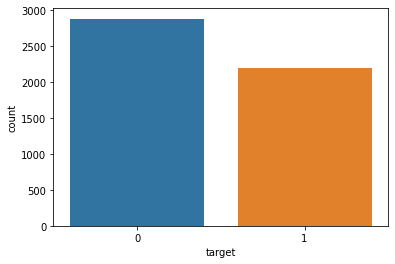

In [8]:
# Visualization of the target distribution

sns.countplot(data['target'])

data['target'].value_counts()

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

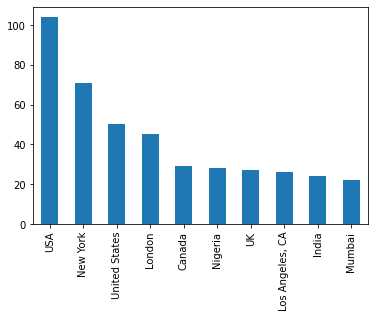

In [9]:
# Visualization of location distribution for the top 10

data.location.value_counts()[:10].plot(kind='bar')

data['location'].value_counts()[:10]

collision                36
whirlwind                33
armageddon               32
fatalities               32
flames                   31
sandstorm                31
derailed                 31
outbreak                 31
emergency%20plan         31
harm                     30
earthquake               30
upheaval                 30
desolation               30
inundated                30
danger                   30
damage                   30
rainstorm                29
airplane%20accident      29
ablaze                   29
sinkhole                 29
flood                    29
collapse                 29
deluge                   29
evacuation               29
displaced                29
buildings%20on%20fire    29
weapons                  29
flattened                29
drought                  28
weapon                   28
Name: keyword, dtype: int64

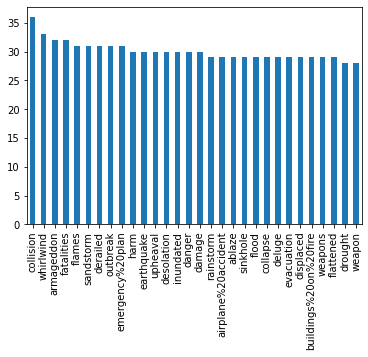

In [10]:
# Visualization of keyword distribution for the top 30

data.keyword.value_counts()[:30].plot(kind='bar')

data['keyword'].value_counts()[:30]

## Part 2 : Data preprocessing

The goal is to clean up the character strings and encode the words so they are represented as integers.

In [11]:
# Download all language elements related to the english language

! python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 27.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [12]:
# Import Spacy and english initialisation
import spacy
nlp = spacy.load("en_core_web_sm")

In [13]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

Text cleaning

In [14]:
# Get all string punctuation that we want to remove. 
import string 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# Remove punctuation

import re
data['text_clean'] = data['text'].apply(lambda x: re.sub('[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+'," ", x)) 
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

data.head()


,id,keyword,location,text,target,text_clean
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale markets ablaze http t co lhyx...
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,we always try to bring the heavy metal rt h...
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking news nigeria flag set ab...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,crying out for more set me ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,on plus side look at the sky last night it was...


In [16]:
# Remove http

for index, row in data.iterrows():
    text=[]
    for word in row['text_clean'].split():
        if "http" not in word:
            text.append(word)
    row['text_clean']=" ".join(text)
    data['text_clean'][index]=row['text_clean']

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,id,keyword,location,text,target,text_clean
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale markets ablaze t co lhyxeohy6c
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,we always try to bring the heavy metal rt t co...
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking news nigeria flag set abl...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,crying out for more set me ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,on plus side look at the sky last night it was...


In [17]:
# Tokenize the cleaned text and remove stop words
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
data.head()

,id,keyword,location,text,target,text_clean
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze t co lhyxeohy6c
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal rt t co yao1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze break news nigeria flag set ablaze...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze t co qqsmshaj3n


In [18]:
#Encoding text and took to only the 1000 most common words

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data.text_clean)
data["text_encoded"] = tokenizer.texts_to_sequences(data.text_clean)
data["len_text"] = data["text_encoded"].apply(lambda x: len(x))
data = data[data["len_text"]!=0]

In [19]:
data

,id,keyword,location,text,target,text_clean,text_encoded,len_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze t co lhyxeohy6c,"[250, 401, 1, 2]",4
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal rt t co yao1e0xngw,"[107, 308, 547, 872, 63, 1, 2]",7
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze break news nigeria flag set ablaze...,"[133, 10, 402, 120, 401, 800, 1, 2]",8
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze,"[744, 120, 401]",3
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze t co qqsmshaj3n,"[24, 585, 202, 401, 1, 2]",6
...,...,...,...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,bright wreck t co uea0txrhys,"[86, 1, 2]",3
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,widda16 relax think wife wreck cake goner mind...,"[31, 86, 570, 840, 112]",5
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,day work pretty wreck hahaha shoutout family,"[20, 36, 634, 86, 29]",5
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,fx forex trading cramer iger 3 word wreck disn...,"[32, 389, 86, 944, 328, 1, 2]",7


In [20]:
# Use of Keras to create token sequences of the same length

text_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_encoded, padding="post")

In [21]:
df = tf.data.Dataset.from_tensor_slices((text_pad, data.target.values))

In [22]:
# Train Val Split

TAKE_SIZE = int(0.8*data.shape[0])

train_data = df.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

val_data = df.skip(TAKE_SIZE)
val_data = val_data.batch(64)

In [23]:
 # Look a batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[170 137   1 ...   0   0   0]
 [480 335 382 ...   0   0   0]
 [ 63  23 117 ...   0   0   0]
 ...
 [425 769 825 ...   0   0   0]
 [  9  82 209 ...   0   0   0]
 [106 404 174 ...   0   0   0]], shape=(64, 23), dtype=int32) tf.Tensor(
[0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0
 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1], shape=(64,), dtype=int64)


## Part 3 : Classification Modeling


### With a SimpleRNN model

In [24]:
vocab_size = len(tokenizer.word_index)

model_simpleRNN = tf.keras.Sequential([          
                  Embedding(vocab_size+1, 64, input_shape=[tweet.shape[1],],name="embedding"),
                  SimpleRNN(units=64, return_sequences=True), 
                  SimpleRNN(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

model_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 64)            942080    
                                                                 
 simple_rnn (SimpleRNN)      (None, 23, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [25]:
# compile model

model_simpleRNN.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [26]:
# Model training 
history = model_simpleRNN.fit(train_data, epochs=10,validation_data = val_data)

Epoch 1/10
64/64 [==============================] - 4s 35ms/step - loss: 0.6594 - binary_accuracy: 0.6215 - val_loss: 0.6195 - val_binary_accuracy: 0.7179
Epoch 2/10
64/64 [==============================] - 2s 29ms/step - loss: 0.6508 - binary_accuracy: 0.6058 - val_loss: 0.6674 - val_binary_accuracy: 0.5414
Epoch 3/10
64/64 [==============================] - 2s 29ms/step - loss: 0.6432 - binary_accuracy: 0.6425 - val_loss: 0.6813 - val_binary_accuracy: 0.5562
Epoch 4/10
64/64 [==============================] - 2s 29ms/step - loss: 0.6517 - binary_accuracy: 0.6072 - val_loss: 0.6827 - val_binary_accuracy: 0.5404
Epoch 5/10
64/64 [==============================] - 2s 29ms/step - loss: 0.6683 - binary_accuracy: 0.5678 - val_loss: 0.6914 - val_binary_accuracy: 0.5414
Epoch 6/10
64/64 [==============================] - 2s 29ms/step - loss: 0.6715 - binary_accuracy: 0.5737 - val_loss: 0.6946 - val_binary_accuracy: 0.5414
Epoch 7/10
64/64 [==============================] - 2s 28ms/step - los

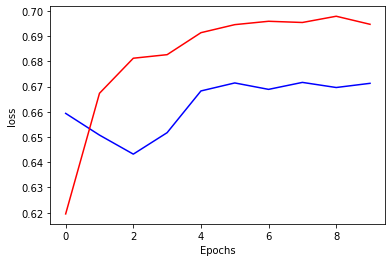

In [27]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

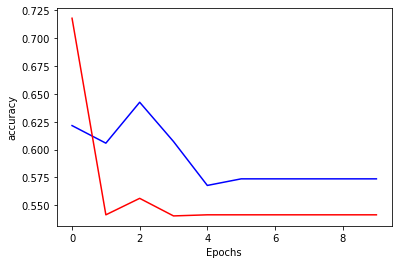

In [28]:
# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

This model is disappointing because the loss goes up and the accuracy goes down

### With a GRU model

In [29]:
model_GRU = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[tweet.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), #
                  GRU(units=32, return_sequences=False), 
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 64)            942080    
                                                                 
 gru (GRU)                   (None, 23, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [30]:
# compile model

model_GRU.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [31]:
history_2= model_GRU.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
64/64 [==============================] - 8s 62ms/step - loss: 0.6851 - binary_accuracy: 0.5703 - val_loss: 0.6900 - val_binary_accuracy: 0.5414
Epoch 2/10
64/64 [==============================] - 3s 48ms/step - loss: 0.6717 - binary_accuracy: 0.5976 - val_loss: 0.5296 - val_binary_accuracy: 0.7544
Epoch 3/10
64/64 [==============================] - 3s 48ms/step - loss: 0.5260 - binary_accuracy: 0.7744 - val_loss: 0.5108 - val_binary_accuracy: 0.7692
Epoch 4/10
64/64 [==============================] - 3s 48ms/step - loss: 0.4646 - binary_accuracy: 0.8176 - val_loss: 0.4859 - val_binary_accuracy: 0.7377
Epoch 5/10
64/64 [==============================] - 5s 72ms/step - loss: 0.4240 - binary_accuracy: 0.8385 - val_loss: 0.4725 - val_binary_accuracy: 0.7840
Epoch 6/10
64/64 [==============================] - 3s 49ms/step - loss: 0.3983 - binary_accuracy: 0.8550 - val_loss: 0.4875 - val_binary_accuracy: 0.7535
Epoch 7/10
64/64 [==============================] - 3s 49ms/step - los

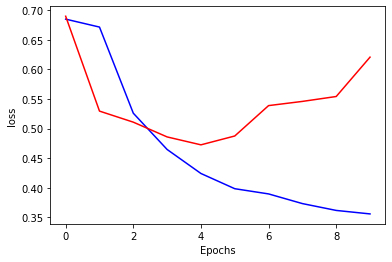

In [32]:
# Visualization of the training process on the loss function 
plt.plot(history_2.history["loss"], color="b")
plt.plot(history_2.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

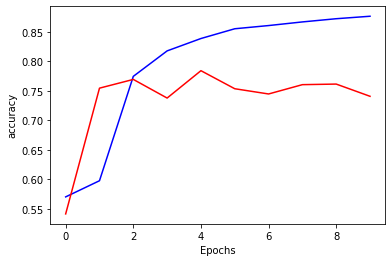

In [33]:
# Visualization of accuracy training 
plt.plot(history_2.history["binary_accuracy"], color="b")
plt.plot(history_2.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

This model is interresting. The curves of train and val follow the same trend until epoch 5 where the model is overfitting.

### With a LSTM model

In [34]:
vocab_size = len(tokenizer.word_index)
model_LSTM = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[tweet.shape[1],],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dropout(0.3),
                  Dense(1, activation="sigmoid")
])

model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 64)            942080    
                                                                 
 lstm (LSTM)                 (None, 23, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [35]:
# compile model

model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [36]:
history_3= model_GRU.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
64/64 [==============================] - 3s 52ms/step - loss: 0.3533 - binary_accuracy: 0.8804 - val_loss: 0.5989 - val_binary_accuracy: 0.7367
Epoch 2/10
64/64 [==============================] - 3s 48ms/step - loss: 0.3384 - binary_accuracy: 0.8797 - val_loss: 0.6979 - val_binary_accuracy: 0.7387
Epoch 3/10
64/64 [==============================] - 3s 47ms/step - loss: 0.3347 - binary_accuracy: 0.8876 - val_loss: 0.7079 - val_binary_accuracy: 0.7456
Epoch 4/10
64/64 [==============================] - 3s 47ms/step - loss: 0.3142 - binary_accuracy: 0.8930 - val_loss: 0.7095 - val_binary_accuracy: 0.7308
Epoch 5/10
64/64 [==============================] - 3s 49ms/step - loss: 0.3192 - binary_accuracy: 0.8964 - val_loss: 0.7996 - val_binary_accuracy: 0.7357
Epoch 6/10
64/64 [==============================] - 3s 48ms/step - loss: 0.3057 - binary_accuracy: 0.8997 - val_loss: 0.8432 - val_binary_accuracy: 0.7219
Epoch 7/10
64/64 [==============================] - 3s 48ms/step - los

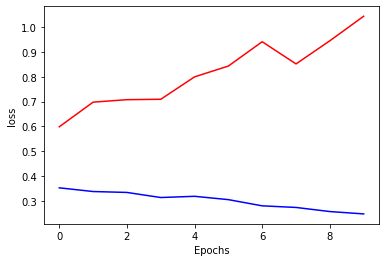

In [37]:
# Visualization of the training process on the loss function 
plt.plot(history_3.history["loss"], color="b")
plt.plot(history_3.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

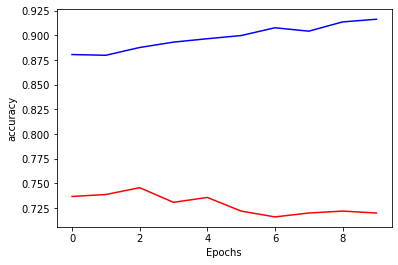

In [38]:
# Visualization of accuracy training 
plt.plot(history_3.history["binary_accuracy"], color="b")
plt.plot(history_3.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

This model is also disappointing, because the model seems to learn something on train set but not is not on val set.

## Part 4 : Conclusion

The best model seems to be the GRU model with an accuracy on the validation set of 78 %.

However, he overfits quickly.

It would be interesting to do a better data cleaning and to "play" with the model parameters to find a better performance.